Ce notebook regroupe l’ensemble d’une chaîne de transmission « half-duplex » comprenant à la fois l’émission et la réception d’un message, ainsi que la gestion d’un accusé de réception (ACK). Le système utilise plusieurs techniques de traitement du signal et de codage (CRC, trame, codage Manchester) ainsi que deux types de modulation (ASK et FSK). Voici une description détaillée du fonctionnement du code, section par section :

---

## 1. Configuration et Paramètres Globaux

- **Imports et Style Graphique :**  
  Le notebook importe `numpy` pour les opérations numériques, `matplotlib.pyplot` pour la visualisation des signaux, et `sounddevice` pour la lecture audio.  
  Le style `ggplot` est appliqué pour obtenir une esthétique graphique uniforme.

- **Définition des Paramètres :**  
  - **Fe (Fréquence d’échantillonnage) :** 44100 Hz  
  - **baud (Débit binaire) :** 200 bits/s  
  - **Ns :** Nombre d’échantillons par bit, calculé par `Fe/baud` (environ 220)  
  - **Porteuses :**  
    - Pour la modulation ASK : 2000 Hz  
    - Pour la modulation FSK : 200 Hz pour le bit 1 et 3000 Hz pour le bit 0

---

## 2. Partie ÉMISSION

### a) Calcul du CRC – `crcemission(bits)`

- **But :**  
  Pour chaque octet (8 bits) du message, le code ajoute 4 bits de redondance calculés via une division par le diviseur binaire `"1001"` (soit 9 en décimal).
  
- **Processus :**  
  - On lit 8 bits du message.
  - On ajoute "0000" à la fin pour former le dividende.
  - On effectue une division entière et on récupère le reste.
  - Le résultat final est constitué de l’octet original suivi du reste (4 bits).
  - Le résultat est affiché puis renvoyé sous forme de liste de bits.

### b) Construction de la Trame – `trame_emission(bits, type_fichier)`

- **But :**  
  La trame de transmission se compose :
  - D’un fanion de début (`[1,1,1,1,1,1,1,1]`),
  - D’un octet de protocole qui varie selon le type de fichier (ex. `"txt"` donne `[1,1,0,0,0,0,1,1]`, `"ack"` donne une autre séquence),
  - Des bits du message (avec leur CRC) et,
  - D’un fanion de fin (`[0,0,0,0,0,0,0,0]`).

### c) Codage Manchester – `Manchester_encode(bits)`

- **Principe :**  
  Le codage Manchester transforme chaque bit en deux bits :
  - Un bit `1` devient `(1, 0)`
  - Un bit `0` devient `(0, 1)`

- **Résultat :**  
  Le message est transformé en une séquence binaire à double cadence, prête pour la modulation.

### d) Modulation et Enregistrement des Signaux – `ASKetFSK_emission(bits_manchester)`

- **Préparation :**  
  - **Duplication des bits :** Chaque bit est répété `Ns` fois pour correspondre aux échantillons temporels.
  - **Création du signal temporel :** Un vecteur de temps `t` est généré selon la fréquence d’échantillonnage.

- **Modulation ASK :**  
  - Une porteuse sinusoïdale à 2000 Hz est générée.
  - Le signal binaire dupliqué module l’amplitude de cette porteuse (multiplication élément par élément).

- **Modulation FSK :**  
  - Deux signaux sinusoïdaux sont générés (200 Hz et 3000 Hz).
  - Pour chaque échantillon, la porteuse choisie dépend de la valeur du bit (1 ou 0).

- **Sauvegarde et Lecture Audio :**  
  - Les signaux modulés sont sauvegardés dans deux fichiers CSV (`Message_ASK.csv` et `Message_FSK.csv`).
  - Les signaux sont joués successivement via `sounddevice`.

- **Graphiques :**  
  Des graphiques illustrent :
  - La version dupliquée du signal Manchester,
  - Le signal ASK modulé,
  - Le signal FSK modulé.

### e) Emission Complète – `emission_complete()`

Cette fonction orchestre toutes les étapes d’émission :
1. **Saisie du message** par l’utilisateur (5 à 10 caractères).
2. **Conversion du texte en binaire ASCII** (8 bits par caractère).
3. **Application du CRC** à l’aide de `crcemission()`.
4. **Construction de la trame** avec `trame_emission()` (le type `"txt"` est utilisé ici).
5. **Encodage Manchester** via `Manchester_encode()`.
6. **Modulation ASK et FSK** et enregistrement des signaux par `ASKetFSK_emission()`.

---

## 3. Partie RÉCEPTION DU MESSAGE

### a) Démodulation du Signal – `retourASKetFSK()`

- **Lecture des Fichiers CSV :**  
  Les signaux modulés ASK et FSK sont lus depuis les fichiers CSV générés lors de l’émission.

- **Démodulation ASK :**
  - La porteuse utilisée lors de l’émission est recréée.
  - Le signal reçu est multiplié par cette porteuse.
  - Le résultat est intégré par blocs de `Ns` échantillons (avec la méthode de trapèze) pour décider, pour chaque bit, s’il vaut 1 (intégrale positive) ou 0.

- **Démodulation FSK (optionnelle) :**
  - Pour chaque bloc, le signal FSK est multiplié par les deux porteuses (200 Hz et 3000 Hz).
  - La comparaison des intégrales permet de déterminer le bit.
  
- **Visualisation :**  
  Plusieurs graphiques sont générés pour montrer :
  - Le signal ASK reçu,
  - Le produit du signal ASK avec la porteuse,
  - Le signal FSK reçu.

- **Retour :**  
  La fonction renvoie la séquence binaire démodulée (côté ASK).

### b) Décodage Manchester – `Manchester_decode(bits)`

- **But :**  
  Reconstituer la séquence originale en regroupant par deux bits.
  
- **Règles :**  
  - Le couple `(1,0)` devient un 1.
  - Le couple `(0,1)` devient un 0.
  - En cas d’incohérence, un message d’erreur est affiché.

### c) Extraction de la Trame – `trame_reception(bits)`

- **Objectif :**  
  Vérifier la présence des fanions de début et de fin, extraire l’octet de protocole, et isoler les données utiles (qui contiennent le CRC).

- **Vérifications :**
  - Le fanion de début doit être `[1,1,1,1,1,1,1,1]`.
  - Le fanion de fin doit être `[0,0,0,0,0,0,0,0]`.
  - L’octet de protocole est alors utilisé pour identifier le type de fichier (par exemple `"txt"` ou `"ack"`).

### d) Vérification du CRC – `crcreception(bits)`

- **Principe :**  
  Le flux de données (extrait de la trame) est lu par blocs de 12 bits (8 bits de données et 4 bits de CRC).  
  Pour chaque bloc :
  - On recalcule le reste en ajoutant « 0000 » aux 8 bits et en divisant par le diviseur (9 en décimal).
  - Si le reste calculé correspond à celui reçu, le bloc est validé.
  - Sinon, l’intégrité globale du message est compromise.
  
- **Résultat :**  
  La fonction renvoie les 8 bits de données par bloc, reconstituant ainsi le message sans CRC, ou indique une erreur si une anomalie est détectée.

### e) Décodage ASCII – `ASCII_decode(bits, type_fichier)`

- **But :**  
  Convertir la séquence binaire (groupée par 8 bits) en texte ASCII.  
- **Processus :**  
  Pour chaque groupe de 8 bits, la valeur décimale correspondante est obtenue puis convertie en caractère ASCII, formant ainsi le message final.

### f) Réception Complète – `reception_complete()`

Cette fonction enchaîne toutes les étapes de la réception du message :
1. **Lecture et démodulation des signaux** avec `retourASKetFSK()`.
2. **Décodage Manchester** avec `Manchester_decode()`.
3. **Extraction de la trame** grâce à `trame_reception()`.
4. **Vérification CRC** via `crcreception()`.
5. **Décodage ASCII** pour reconstituer le message final.

---

## 4. Gestion de l'ACKNOWLEDGMENT (ACK)

Le système gère également l’envoi d’un accusé de réception (ACK) :

### a) Emission de l’ACK – `emission_acknowledgment()`

- **Fonctionnement similaire à l’émission du message :**  
  - Le texte « ACK » est converti en binaire.
  - Un CRC est calculé.
  - Une trame est construite avec un protocole spécifique (ici, le type `"ack"`).
  - Le codage Manchester est appliqué.
  - La modulation ASK et FSK est effectuée et les signaux sont sauvegardés dans des fichiers dédiés (`Ack_ASK.csv` et `Ack_FSK.csv`).

### b) Réception de l’ACK – `retourASKetFSK_ack()` et `reception_acknowledgment()`

- **Lecture des CSV ACK :**  
  La fonction `retourASKetFSK_ack()` lit les signaux d’ACK depuis les fichiers CSV, puis réalise la démodulation (similaire à celle du message).
  
- **Décodage et vérification :**  
  Après décodage Manchester et extraction de la trame, le CRC est vérifié puis le message ACK est reconstruit en ASCII via `ASCII_decode()`.
  
- **Finalité :**  
  L’émetteur peut ainsi confirmer que le message initial a bien été reçu.

---

## 5. Chaîne Complète Half-Duplex

La partie finale du notebook présente la démonstration de la chaîne complète :

1. **Phase 1 : Émission du Message**  
   La fonction `emission_complete()` est appelée pour traiter le message saisi par l’utilisateur et émettre les signaux modulés.

2. **Phase 2 : Réception du Message**  
   La fonction `reception_complete()` permet au récepteur de lire, démoduler et décoder le message.

3. **Phase 3 : Emission de l’ACK**  
   Si le message est correctement reçu, le récepteur envoie un ACK en appelant `emission_acknowledgment()`.

4. **Phase 4 : Réception de l’ACK**  
   L’émetteur lit et démodule l’ACK via `reception_acknowledgment()` pour confirmer la bonne réception.

---

## Conclusion

Ce notebook met en œuvre une chaîne de transmission complète en mode half-duplex en simulant :
- La **conversion ASCII** du texte en binaire,
- L’**ajout de redondance (CRC)**,
- La **construction d’une trame** avec fanions et protocole,
- Le **codage Manchester**,
- La **modulation** (ASK et FSK) et leur **sauvegarde** en CSV,
- La **démodulation** et le **décodage** du signal reçu,
- Et enfin la **gestion d’un accusé de réception**.

Chaque étape est accompagnée d’affichages et de graphiques pour visualiser les signaux, ce qui permet de mieux comprendre le fonctionnement global de la transmission et de la réception dans un environnement de simulation.

CHAÎNE DE TRANSMISSION HALF DUPLEX : ÉMISSION, RÉCEPTION, ACK

--- PHASE 1 : ÉMISSION DU MESSAGE ---
=== ÉMISSION : Conversion ASCII ===
Texte en binaire : [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]
=== ÉMISSION : CRC ===
Résultat CRC : [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
=== ÉMISSION : TRAME ===
Octet protocole : [1, 1, 0, 0, 0, 0, 1, 1]
Fanion de début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion de fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Trame complète  : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
=== ÉMISSION : Manchester encode ===
Manchester (extrait) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] ...
=== ÉMISSION : Modulation ===
Signal ASK (extrait) : [0.         0.28111111 0.53955074 0.75447585 0.90855282 0.98935543
 0.99036696 0.91150585 0.75913221 0.5455349 ] ...
Signal FSK (extrait) : [0.         0.02849132 0.0569595  0.08538143 0.11

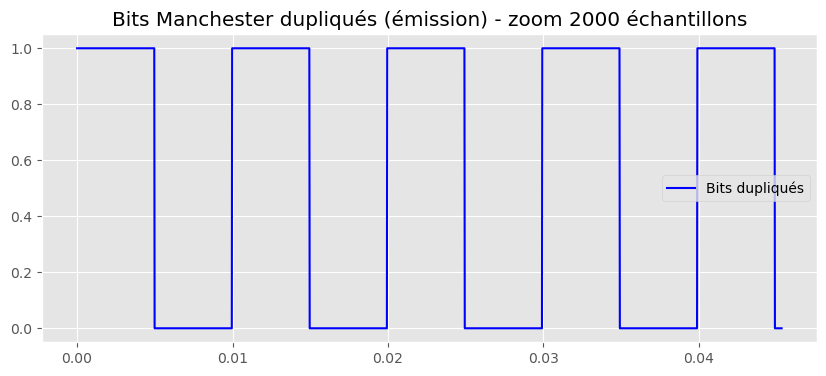

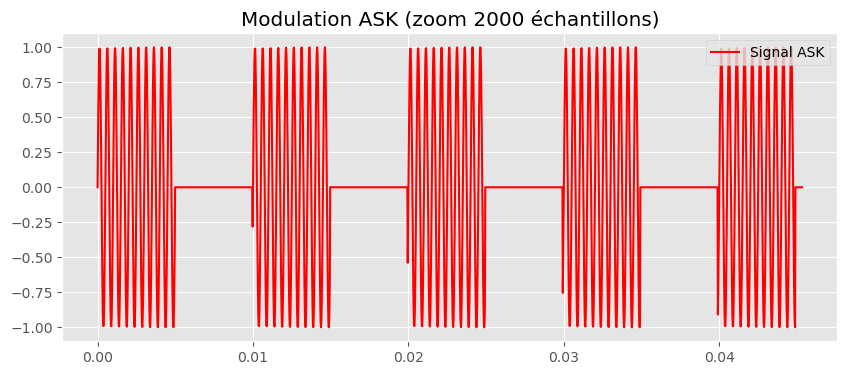

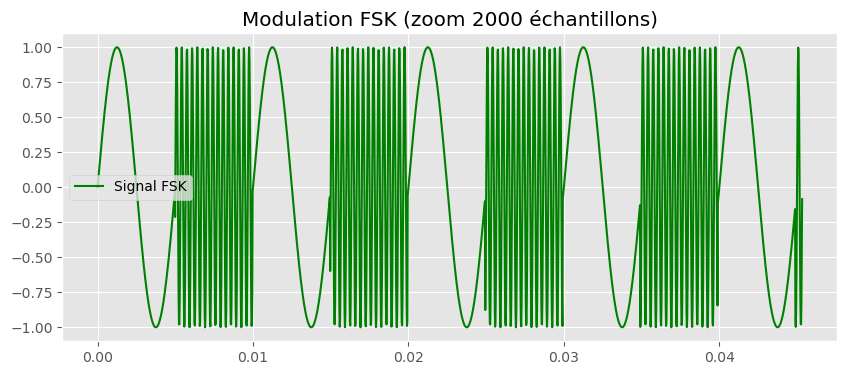


--- PHASE 2 : RÉCEPTION DU MESSAGE ---
=== RÉCEPTION : Lecture CSV ===
ASK (extrait) : [0.       0.281111 0.539551 0.754476 0.908553 0.989355 0.990367 0.911506
 0.759132 0.545535] ...
FSK (extrait) : [0.       0.028491 0.056959 0.085381 0.113734 0.141994 0.170139 0.198146
 0.225992 0.253655] ...
=== RÉCEPTION : Démodulation ===
Bits démodulés ASK (extrait) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1] ...
Bits démodulés FSK (extrait) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1] ...


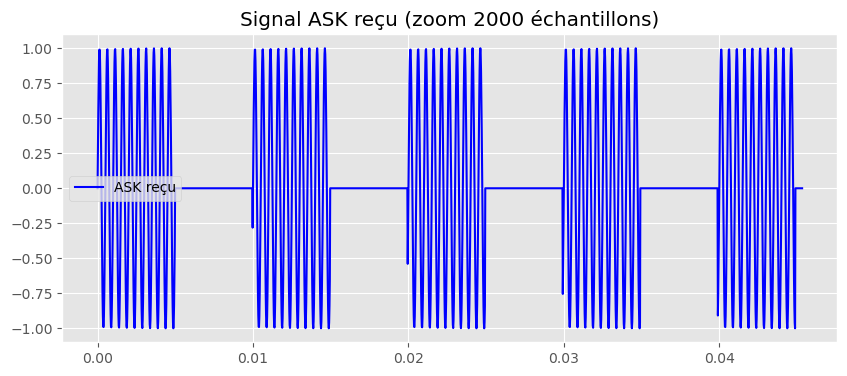

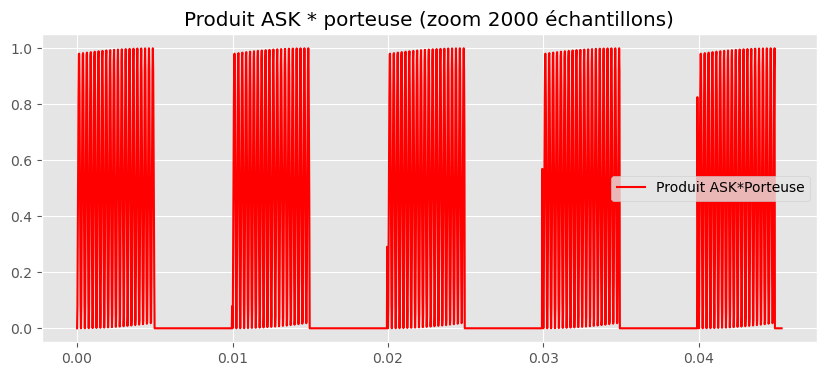

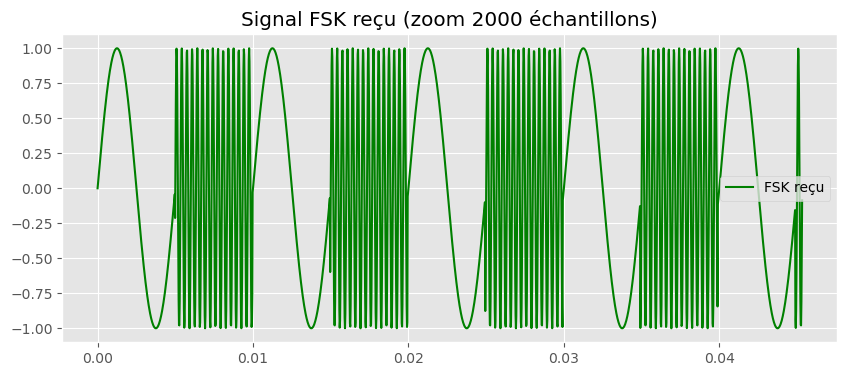

=== RÉCEPTION : Manchester decode ===
Décodage (extrait) : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0] ...
=== RÉCEPTION : Trame ===
Fanion début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Protocole : [1, 1, 0, 0, 0, 0, 1, 1]
Type de fichier : txt
=== RÉCEPTION : CRC OK ===
Données après retrait CRC : [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]
=== RÉCEPTION : ASCII ===
Message reconstitué : ff
Message reçu avec succès : ff

--- PHASE 3 : EMISSION DE L'ACK (par le récepteur) ---
=== EMISSION ACK : Conversion ASCII ===
Texte ACK en binaire : [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
=== ÉMISSION : CRC ===
Résultat CRC : [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
=== ÉMISSION : TRAME ===
Octet protocole : [1, 0, 1, 0, 1, 0, 1, 0]
Fanion de début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion de fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Trame complète  : [1, 1, 1, 1, 1,

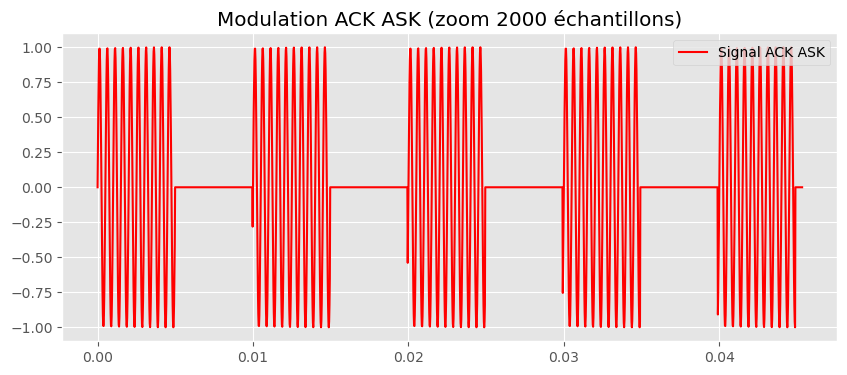


--- PHASE 4 : RÉCEPTION DE L'ACK (par l'émetteur) ---
=== RÉCEPTION ACK : Lecture CSV ===
ACK ASK (extrait) : [0.       0.281111 0.539551 0.754476 0.908553 0.989355 0.990367 0.911506
 0.759132 0.545535] ...
ACK FSK (extrait) : [0.       0.028491 0.056959 0.085381 0.113734 0.141994 0.170139 0.198146
 0.225992 0.253655] ...
=== RÉCEPTION ACK : Démodulation ===
Bits ACK démodulés ASK (extrait) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1] ...
=== RÉCEPTION : Manchester decode ===
Décodage (extrait) : [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0] ...
=== RÉCEPTION : Trame ===
Fanion début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Protocole : [1, 0, 1, 0, 1, 0, 1, 0]
Type de fichier : ack
=== RÉCEPTION : CRC OK ===
Données après retrait CRC : [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
=== RÉCEPTION : ASCII ===
Message reconstitué : ACK
ACK reçu : ACK


In [1]:
###############################################################################
#                         NOTEBOOK : EMISSION & RECEPTION
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

# Pour un style de graphique "ggplot" plus agréable
plt.style.use('ggplot')

###############################################################################
#                           PARAMÈTRES GLOBAUX
###############################################################################
Fe   = 44100   # Fréquence d'échantillonnage
baud = 200     # Débit binaire (bits/s)
Ns   = int(Fe / baud)  # Nombre d'échantillons par bit ~ 220
Fp_ASK = 2000  # Porteuse ASK
fp1    = 200   # Porteuse FSK (bit=1)
fp2    = 3000  # Porteuse FSK (bit=0)

###############################################################################
#                    1) EMISSION
###############################################################################

def crcemission(bits):
    """
    Calcule un CRC 4 bits (diviseur = '1001', soit 9 décimal) pour chaque octet.
    On lit 8 bits, on ajoute '0000', on divise, on récupère le reste, 
    et on l'ajoute au flux.
    """
    diviseur = int("1001", 2)  # 9 décimal
    resultat_crc = []
    bits_local = bits.copy()

    while len(bits_local) >= 8:
        donne_str = ''.join(map(str, bits_local[:8]))  # 8 bits
        bits_local = bits_local[8:]

        # Ajout "0000"
        donne_str_dividende = donne_str + "0000"
        donne_int_dividende = int(donne_str_dividende, 2)

        # Division
        _, reste = divmod(donne_int_dividende, diviseur)

        # On réinsère l'octet (8 bits) + 4 bits de CRC
        donnee_int = format(int(donne_str, 2), '08b')
        resultat_crc.extend(map(int, donnee_int))
        resultat_crc.extend(map(int, format(reste, '04b')))

    print("=== ÉMISSION : CRC ===")
    print("Résultat CRC :", resultat_crc)
    return resultat_crc

def trame_emission(bits, type_fichier):
    """
    Construit la trame :
      - fanion de début (11111111)
      - octet de protocole
      - bits + CRC
      - fanion de fin (00000000)
    Le protocole dépend du type de fichier :
      - "txt" : [1,1,0,0,0,0,1,1]
      - "ack" : [1,0,1,0,1,0,1,0]
    """
    fanion_debut = [1,1,1,1,1,1,1,1]
    fanion_fin   = [0,0,0,0,0,0,0,0]

    if type_fichier == "txt":
        protocole = [1,1,0,0,0,0,1,1]
    elif type_fichier == "ack":
        protocole = [1,0,1,0,1,0,1,0]
    else:
        protocole = [0,0,0,0,0,0,0,0]  # Par défaut

    bits_final = fanion_debut + protocole + bits + fanion_fin

    print("=== ÉMISSION : TRAME ===")
    print("Octet protocole :", protocole)
    print("Fanion de début :", fanion_debut)
    print("Fanion de fin   :", fanion_fin)
    print("Trame complète  :", bits_final)
    return bits_final

def Manchester_encode(bits):
    """
    Codage Manchester :
      - 1 => (1,0)
      - 0 => (0,1)
    """
    code = []
    for b in bits:
        if b == 1:
            code.extend([1,0])
        else:
            code.extend([0,1])
    print("=== ÉMISSION : Manchester encode ===")
    print("Manchester (extrait) :", code[:20], "...")
    return code

def ASKetFSK_emission(bits_manchester):
    """
    Modulation ASK & FSK pour le message principal,
    sauvegarde dans 2 CSV, lecture audio (optionnel), et affichage graphique.
    """
    # On duplique le flux binaire : 1 bit => Ns échantillons
    bits_dupliques = np.repeat(bits_manchester, Ns)
    N = len(bits_dupliques)
    t = np.arange(N) / Fe

    # ASK : multiplication bits_dupliques * sin(2pi Fp_ASK t)
    porteuse_ASK = np.sin(2*np.pi*Fp_ASK*t)
    ASK = bits_dupliques * porteuse_ASK

    # FSK : si bit=1 => sin(2pi fp1 t), sinon sin(2pi fp2 t)
    s1 = np.sin(2*np.pi*fp1*t)
    s2 = np.sin(2*np.pi*fp2*t)
    FSK = np.where(bits_dupliques==1, s1, s2)

    # Sauvegarde
    np.savetxt("Message_ASK.csv", ASK, fmt="%.6f", delimiter=',')
    np.savetxt("Message_FSK.csv", FSK, fmt="%.6f", delimiter=',')

    print("=== ÉMISSION : Modulation ===")
    print("Signal ASK (extrait) :", ASK[:10], "...")
    print("Signal FSK (extrait) :", FSK[:10], "...")

    # Lecture audio (si souhaité, commenter si problème PortAudio)
    sd.play(ASK, Fe)
    sd.wait()
    sd.play(FSK, Fe)
    sd.wait()

    # Graphiques
    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], bits_dupliques[:2000], color='blue', label='Bits dupliqués')
    plt.title("Bits Manchester dupliqués (émission) - zoom 2000 échantillons")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], ASK[:2000], color='red', label='Signal ASK')
    plt.title("Modulation ASK (zoom 2000 échantillons)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], FSK[:2000], color='green', label='Signal FSK')
    plt.title("Modulation FSK (zoom 2000 échantillons)")
    plt.legend()
    plt.grid(True)

    plt.show()

def ASKetFSK_emission_ack(bits_manchester):
    """
    Modulation ASK & FSK pour l'accusé de réception (ACK).
    La seule différence ici est la sauvegarde dans des CSV différents.
    """
    bits_dupliques = np.repeat(bits_manchester, Ns)
    N = len(bits_dupliques)
    t = np.arange(N) / Fe

    porteuse_ASK = np.sin(2*np.pi*Fp_ASK*t)
    ASK = bits_dupliques * porteuse_ASK

    s1 = np.sin(2*np.pi*fp1*t)
    s2 = np.sin(2*np.pi*fp2*t)
    FSK = np.where(bits_dupliques==1, s1, s2)

    np.savetxt("Ack_ASK.csv", ASK, fmt="%.6f", delimiter=',')
    np.savetxt("Ack_FSK.csv", FSK, fmt="%.6f", delimiter=',')

    print("=== ÉMISSION ACK : Modulation ===")
    print("Signal ACK ASK (extrait) :", ASK[:10], "...")
    print("Signal ACK FSK (extrait) :", FSK[:10], "...")

    sd.play(ASK, Fe)
    sd.wait()
    sd.play(FSK, Fe)
    sd.wait()

    # Graphiques (optionnels)
    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], ASK[:2000], color='red', label='Signal ACK ASK')
    plt.title("Modulation ACK ASK (zoom 2000 échantillons)")
    plt.legend()
    plt.grid(True)
    plt.show()

def emission_complete():
    """
    PHASE ÉMISSION : 
      1) Saisie du message
      2) Conversion ASCII -> binaire
      3) CRC
      4) Trame
      5) Manchester encode
      6) Modulation (ASK & FSK)
    """
    texte = ""
    while not texte:
        texte = input("Saisissez votre message (5-10 caractères) : ")

    # Conversion ASCII -> binaire (8 bits par caractère)
    bits_texte = []
    for char in texte:
        binaire = format(ord(char), '08b')
        bits_texte.extend(int(b) for b in binaire)

    print("=== ÉMISSION : Conversion ASCII ===")
    print("Texte en binaire :", bits_texte)

    # 1) CRC
    bits_crc = crcemission(bits_texte)
    # 2) Trame (type "txt")
    bits_trame = trame_emission(bits_crc, "txt")
    # 3) Codage Manchester
    bits_manchester = Manchester_encode(bits_trame)
    # 4) Modulation & enregistrement
    ASKetFSK_emission(bits_manchester)

###############################################################################
#                    2) RECEPTION DU MESSAGE
###############################################################################

def retourASKetFSK():
    """
    Lit 'Message_ASK.csv' (ASK) et 'Message_FSK.csv' (FSK), 
    effectue la démodulation et affiche des graphes.
    Retourne la séquence binaire (liste 0/1) côté ASK.
    """
    # Lecture CSV
    ASK_signal = np.genfromtxt("Message_ASK.csv", delimiter=',')
    FSK_signal = np.genfromtxt("Message_FSK.csv", delimiter=',')
    print("=== RÉCEPTION : Lecture CSV ===")
    print("ASK (extrait) :", ASK_signal[:10], "...")
    print("FSK (extrait) :", FSK_signal[:10], "...")

    N = len(ASK_signal)
    t = np.arange(N) / Fe

    # Démodulation ASK
    porteuse = np.sin(2*np.pi*Fp_ASK*t)
    produit  = ASK_signal * porteuse

    # Intégration par paquets de Ns
    bits_ask = []
    for i in range(0, N, Ns):
        portion = produit[i:i+Ns]
        integ = np.trapz(portion)
        bits_ask.append(1 if integ>0 else 0)

    # Démodulation FSK (optionnel, pour visualisation)
    s1 = np.sin(2*np.pi*fp1*t)
    s2 = np.sin(2*np.pi*fp2*t)
    res1, res2 = [], []
    for i in range(0, N, Ns):
        portion1 = FSK_signal[i:i+Ns] * s1[i:i+Ns]
        portion2 = FSK_signal[i:i+Ns] * s2[i:i+Ns]
        res1.append(np.trapz(portion1))
        res2.append(np.trapz(portion2))
    bits_fsk = [1 if r1>r2 else 0 for (r1,r2) in zip(res1,res2)]

    print("=== RÉCEPTION : Démodulation ===")
    print("Bits démodulés ASK (extrait) :", bits_ask[:50], "...")
    print("Bits démodulés FSK (extrait) :", bits_fsk[:50], "...")

    # Graphiques
    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], ASK_signal[:2000], color='blue', label="ASK reçu")
    plt.title("Signal ASK reçu (zoom 2000 échantillons)")
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], produit[:2000], color='red', label="Produit ASK*Porteuse")
    plt.title("Produit ASK * porteuse (zoom 2000 échantillons)")
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(10,4))
    plt.plot(t[:2000], FSK_signal[:2000], color='green', label="FSK reçu")
    plt.title("Signal FSK reçu (zoom 2000 échantillons)")
    plt.grid(True)
    plt.legend()

    plt.show()

    return bits_ask

def Manchester_decode(bits):
    """
    Décodage Manchester (RÉCEPTION):
      - (1,0) => 1
      - (0,1) => 0
    """
    decode = []
    for i in range(0, len(bits)//2):
        b1 = bits[2*i]
        b2 = bits[2*i + 1]
        if (b1, b2) == (1,0):
            decode.append(1)
        elif (b1, b2) == (0,1):
            decode.append(0)
        else:
            # Erreur ou motif inconnu
            print("Erreur de décodage Manchester à l'index", i)
    print("=== RÉCEPTION : Manchester decode ===")
    print("Décodage (extrait) :", decode[:20], "...")
    return decode

def trame_reception(bits):
    """
    Extraction de la trame :
      - Vérification du fanion de début (11111111) et de fin (00000000)
      - Extraction de l'octet protocole et des données (avec CRC)
    Retourne (data, type_fichier).
    """
    if len(bits) < 16:
        print("Trame trop courte pour fanions. Annulation.")
        return None, None

    fanion_debut = bits[:8]
    fanion_fin   = bits[-8:]
    core = bits[8:-8]

    print("=== RÉCEPTION : Trame ===")
    print("Fanion début :", fanion_debut)
    print("Fanion fin   :", fanion_fin)

    if fanion_debut != [1]*8 or fanion_fin != [0]*8:
        print("Fanions incorrects. Annulation.")
        return None, None

    if len(core) < 8:
        print("Pas assez de bits pour le protocole.")
        return None, None

    protocole = core[:8]
    data = core[8:]
    print("Protocole :", protocole)

    if protocole == [1,1,0,0,0,0,1,1]:
        type_fic = "txt"
        print("Type de fichier : txt")
    elif protocole == [1,0,1,0,1,0,1,0]:
        type_fic = "ack"
        print("Type de fichier : ack")
    else:
        print("Protocole inconnu.")
        return None, None

    return data, type_fic

def crcreception(bits):
    """
    Relit par blocs de 12 bits (8 data + 4 CRC).
    Recalcule le reste avec le diviseur '1001' et compare.
    """
    diviseur = int("1001", 2)
    idx = 0
    data_reconstruit = []
    integrite_ok = True

    while idx + 12 <= len(bits):
        bloc = bits[idx:idx+12]
        idx += 12
        data_8 = bloc[:8]
        reste_4 = bloc[8:]

        # Recalcule
        data_str = "".join(str(b) for b in data_8)
        data_plus_0000 = data_str + "0000"
        data_dec = int(data_plus_0000, 2)
        reste_calc_dec = data_dec % diviseur
        reste_calc_str = format(reste_calc_dec, '04b')

        reste_recu_str = "".join(str(x) for x in reste_4)
        if reste_calc_str != reste_recu_str:
            integrite_ok = False

        data_reconstruit.extend(data_8)

    if integrite_ok:
        print("=== RÉCEPTION : CRC OK ===")
        print("Données après retrait CRC :", data_reconstruit)
        return data_reconstruit
    else:
        print("=== RÉCEPTION : CRC incorrect ===")
        return None

def ASCII_decode(bits, type_fichier):
    """
    Convertit la liste binaire (8 bits = 1 caractère ASCII) en texte.
    """
    if not bits:
        print("Données vides.")
        return

    bin_str = "".join(str(b) for b in bits)
    message = ""
    for i in range(0, len(bin_str), 8):
        octet = bin_str[i:i+8]
        if len(octet) < 8:
            break
        decimal_val = int(octet, 2)
        message += chr(decimal_val)

    print("=== RÉCEPTION : ASCII ===")
    print("Message reconstitué :", message)
    return message

def reception_complete():
    """
    PHASE RÉCEPTION MESSAGE :
      1) Lecture CSV, démodulation ASK & FSK
      2) Décodage Manchester
      3) Extraction de la trame
      4) Vérification CRC
      5) Décodage ASCII
    """
    bits_ask = retourASKetFSK()
    bits_decode = Manchester_decode(bits_ask)
    data_trame, type_fic = trame_reception(bits_decode)
    if data_trame is None or type_fic is None:
        print("Trame invalide. Stop.")
        return None
    data_sans_crc = crcreception(data_trame)
    if data_sans_crc is None:
        print("CRC invalide. Stop.")
        return None
    message = ASCII_decode(data_sans_crc, type_fic)
    return message

###############################################################################
#             3) EMISSION & RECEPTION DE L'ACKNOWLEDGMENT (ACK)
###############################################################################

def emission_acknowledgment():
    """
    Le récepteur envoie un ACK (texte "ACK") si le message reçu est correct.
    """
    texte = "ACK"
    bits_texte = []
    for char in texte:
        binaire = format(ord(char), '08b')
        bits_texte.extend(int(b) for b in binaire)

    print("=== EMISSION ACK : Conversion ASCII ===")
    print("Texte ACK en binaire :", bits_texte)

    bits_crc = crcemission(bits_texte)
    bits_trame = trame_emission(bits_crc, "ack")
    bits_manchester = Manchester_encode(bits_trame)
    ASKetFSK_emission_ack(bits_manchester)

def retourASKetFSK_ack():
    """
    Lit 'Ack_ASK.csv' et 'Ack_FSK.csv', démodule le signal ACK.
    Retourne la séquence binaire (liste 0/1) côté ASK.
    """
    ASK_signal = np.genfromtxt("Ack_ASK.csv", delimiter=',')
    FSK_signal = np.genfromtxt("Ack_FSK.csv", delimiter=',')
    print("=== RÉCEPTION ACK : Lecture CSV ===")
    print("ACK ASK (extrait) :", ASK_signal[:10], "...")
    print("ACK FSK (extrait) :", FSK_signal[:10], "...")

    N = len(ASK_signal)
    t = np.arange(N) / Fe

    porteuse = np.sin(2*np.pi*Fp_ASK*t)
    produit  = ASK_signal * porteuse

    bits_ask = []
    for i in range(0, N, Ns):
        portion = produit[i:i+Ns]
        integ = np.trapz(portion)
        bits_ask.append(1 if integ>0 else 0)

    # Optionnel : on peut également démouler le signal FSK pour vérification

    print("=== RÉCEPTION ACK : Démodulation ===")
    print("Bits ACK démodulés ASK (extrait) :", bits_ask[:20], "...")
    return bits_ask

def reception_acknowledgment():
    """
    Le récepteur d'ACK (typiquement l'émetteur) lit les CSV ACK, démodule, et
    traite l'ACK.
    """
    bits_ask = retourASKetFSK_ack()
    bits_decode = Manchester_decode(bits_ask)
    data_trame, type_fic = trame_reception(bits_decode)
    if data_trame is None or type_fic is None:
        print("Trame ACK invalide. Stop.")
        return None
    data_sans_crc = crcreception(data_trame)
    if data_sans_crc is None:
        print("CRC ACK invalide. Stop.")
        return None
    message = ASCII_decode(data_sans_crc, type_fic)
    return message

###############################################################################
#                  DÉMONSTRATION : CHAÎNE COMPLETE HALF DUPLEX
###############################################################################

print("============================================================")
print("CHAÎNE DE TRANSMISSION HALF DUPLEX : ÉMISSION, RÉCEPTION, ACK")
print("============================================================")

# --- Phase 1 : Émission du message par l'émetteur ---
print("\n--- PHASE 1 : ÉMISSION DU MESSAGE ---")
emission_complete()

# --- Phase 2 : Réception du message par le récepteur ---
print("\n--- PHASE 2 : RÉCEPTION DU MESSAGE ---")
message_recu = reception_complete()
if message_recu is not None:
    print("Message reçu avec succès :", message_recu)
    # --- Phase 3 : Envoi de l'ACK par le récepteur ---
    print("\n--- PHASE 3 : EMISSION DE L'ACK (par le récepteur) ---")
    emission_acknowledgment()
else:
    print("Erreur lors de la réception du message. ACK non envoyé.")

# --- Phase 4 : Réception de l'ACK par l'émetteur ---
print("\n--- PHASE 4 : RÉCEPTION DE L'ACK (par l'émetteur) ---")
ack_recu = reception_acknowledgment()
if ack_recu is not None:
    print("ACK reçu :", ack_recu)
else:
    print("ACK non reçu ou invalide.")


Les deux codes mettent en œuvre essentiellement la même chaîne de transmission en mode half‑duplex (émission, réception et échange d’ACK) en passant par les mêmes étapes fondamentales :

- Conversion du message ASCII en binaire  
- Calcul du CRC sur chaque octet (avec le diviseur binaire « 1001 »)  
- Construction d’une trame (ajout de fanions de début et de fin, et d’un octet de protocole)  
- Encodage en Manchester  
- Modulation en ASK et FSK (avec duplication temporelle des bits pour obtenir Ns échantillons par bit)  
- Sauvegarde des signaux modulés dans des fichiers CSV  
- Démodulation (par multiplication par la porteuse et intégration par blocs)  
- Décodage Manchester, extraction de la trame, vérification du CRC et reconstitution du message ASCII  
- Et enfin, la gestion d’un accusé de réception (ACK) via le même processus

Cependant, plusieurs différences (souvent de style ou de détails d’implémentation) distinguent ces deux versions :

---

### 1. Structure et Organisation du Code

- **Organisation en modules/fonctions :**  
  - **Premier code :**  
    Il regroupe l’ensemble des fonctions d’émission, de réception et de gestion d’ACK dans un seul script. La fonction principale s’appelle `send_message_and_receive_ack()` qui orchestre toutes les phases (émission du message, réception, émission de l’ACK puis réception de l’ACK) et est appelée dans le bloc  
    ```python
    if __name__=="__main__":
        send_message_and_receive_ack()
    ```
  - **Deuxième code (NOTBOOK : EMISSION & RECEPTION) :**  
    La structure est organisée en deux grandes parties :  
    1. La phase **ÉMISSION** (avec des fonctions comme `crcemission()`, `trame_emission()`, `Manchester_encode()`, puis `ASKetFSK_emission()`)  
    2. La phase **RÉCEPTION** (avec des fonctions telles que `retourASKetFSK()`, `Manchester_decode()`, `trame_reception()`, `crcreception()`, et `ASCII_decode()`)  
    Puis, après ces deux parties, le code gère séparément la transmission/réception de l’ACK avec des fonctions spécifiques (`emission_acknowledgment()`, `retourASKetFSK_ack()`, `reception_acknowledgment()`) et enfin une démonstration qui enchaîne toutes les phases (émission, réception du message, émission d’ACK, réception d’ACK).

---

### 2. Détails de l’Implémentation

- **Niveau de verbosité et affichages :**  
  - Le deuxième code affiche de nombreux messages informatifs (titres, extraits de signaux, vérifications de fanions, erreurs éventuelles lors du décodage Manchester, etc.) afin d’accompagner l’utilisateur et de faciliter le débogage.  
  - Le premier code est un peu plus « succinct » dans ses affichages, même s’il réalise les mêmes étapes (par exemple, il affiche « Bits dupliqués (Manchester) » et les signaux modulés, mais avec moins de détails).

- **Gestion des protocoles :**  
  - Dans le deuxième code, la fonction `trame_emission()` gère explicitement deux types de protocole (pour un fichier texte `"txt"` et pour un accusé de réception `"ack"`), alors que dans le premier code, le choix se fait principalement en passant l’argument `"txt"` (même si on voit aussi la possibilité de choisir `"ack"` dans la fonction `trame_emission()`).
  
- **Sauvegarde et lecture des fichiers :**  
  - Dans les deux codes, la modulation sauvegarde les signaux modulés dans des fichiers CSV et les lit ensuite pour la démodulation.  
  - Dans le deuxième code, on voit une séparation plus nette entre la phase d’émission (fonction `ASKetFSK_emission()`) et la phase de réception (fonction `retourASKetFSK()`), ainsi que la gestion spécifique des fichiers pour l’ACK (avec des noms de fichiers différents comme `"Ack_ASK.csv"` et `"Ack_FSK.csv"`).

- **Graphiques et visualisations :**  
  - Les deux codes affichent des graphiques pour visualiser les signaux (bits dupliqués, ASK, FSK) en zoomant sur une partie du signal (par exemple, les 2000 premiers échantillons).  
  - Le deuxième code propose plusieurs figures avec des titres et des légendes détaillées pour chaque étape (trame, Manchester, modulation ASK et FSK).

---

### 3. Gestion de la Chaîne Half‑Duplex

- **Fonction d’orchestration :**  
  - **Premier code :**  
    La fonction `send_message_and_receive_ack()` orchestre directement les quatre phases de communication (émission du message, réception du message, émission de l’ACK, réception de l’ACK).
  - **Deuxième code :**  
    La démonstration est divisée en deux grandes parties (émission/réception du message et ensuite émission/réception de l’ACK) et affiche clairement les différentes phases en les séparant par des titres (ex. « PHASE 1 : ÉMISSION DU MESSAGE », « PHASE 2 : RÉCEPTION DU MESSAGE », etc.).

---

### En Résumé

Bien que les deux codes réalisent les mêmes étapes fondamentales pour la transmission en mode half‑duplex avec accusé de réception, leurs différences se situent principalement dans :

1. **L’organisation et la structure du code :**  
   Le premier code regroupe tout dans une fonction principale unique, tandis que le deuxième code est découpé en parties distinctes (émission, réception, ACK) avec une gestion plus détaillée.

2. **Le niveau de verbosité et d’affichage :**  
   Le deuxième code propose plus de messages d’information et des affichages détaillés pour chaque étape, ce qui facilite la compréhension et le débogage.

3. **La gestion des protocoles et des fichiers pour l’ACK :**  
   Le deuxième code introduit explicitement la possibilité de distinguer le type de trame (texte vs ACK) via l’octet de protocole et utilise des fichiers CSV différents pour les signaux ACK.

En somme, les deux codes accomplissent le même objectif fonctionnel, mais le deuxième offre une organisation plus modulée et une traçabilité plus fine de chaque étape du processus de transmission et de réception.